In [1]:
%matplotlib inline

import gym
import gym_matchmaking
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

import sklearn.pipeline
import sklearn.preprocessing

if "../../reinforcement-learning/" not in sys.path:
  sys.path.append("../../reinforcement-learning/") 
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("Matchmaking-harder-v0")
env.observation_space.sample()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([0.5488135 , 0.71518934, 0.60276335, 0.5448832 , 0.4236548 ,
       0.6458941 , 0.4375872 , 0.891773  , 0.96366274, 0.3834415 ],
      dtype=float32)

In [3]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [4]:
def featurize_state(state):
    """
    Returns the featurized representation for a state.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

In [5]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [10], "state")
            self.action = tf.placeholder(dtype=tf.int32, shape=[2], name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            self.h1 = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=16,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.zeros_initializer
            )
            
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.h1, 0),
                num_outputs=env.action_space.spaces[0].n,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer
            )

            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            self.picked_action_prob1 = tf.gather(self.action_probs, self.action[0])
            self.picked_action_prob2 = tf.gather(self.action_probs, self.action[1])
            self.picked_action_prob = self.picked_action_prob1 * self.picked_action_prob2

            # Loss and train op
            self.loss = -tf.log(self.picked_action_prob) * self.target

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_probs, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [6]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            self.h1 = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=16,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.zeros_initializer
            )
            
            
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.h1, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [7]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        episode = []
        abstentions = 0
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action1 = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            if action1 != 10:
                removedProb = action_probs[action1] + action_probs[10]
                action_probs[action1] = 0
                action_probs[10] = 0
                for idx in range(len(action_probs)):
                    if idx != action1 and idx != 10:
                        action_probs[idx] += removedProb/(10-1)
                action2 = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            else:
                action2 = 10
            action = (action1, action2)
            if action == (10,10):
                abstentions+=1
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=np.reshape(action, [2]), reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update the value estimator
            estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.

            if done or t == 200:
                break
                
            state = next_state
        print("\rStep {} @ Episode {}/{} ({}, {})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1], abstentions))
    return stats

In [12]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(learning_rate=0.001)
value_estimator = ValueEstimator(learning_rate=0.1)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need varies
    # TODO: Sometimes the algorithm gets stuck, I'm not sure what exactly is happening there.
    stats = actor_critic(env, policy_estimator, value_estimator, 10000, discount_factor=0.95)

Step 200 @ Episode 1/10000 (0.0, 24)
Step 200 @ Episode 2/10000 (-6.658367583349662, 18)
Step 200 @ Episode 3/10000 (-6.014212462501401, 21)
Step 200 @ Episode 4/10000 (-6.953782948591407, 29)
Step 200 @ Episode 5/10000 (-6.354274796531508, 21)
Step 200 @ Episode 6/10000 (-4.956223233182888, 19)
Step 200 @ Episode 7/10000 (-6.958286452340126, 30)
Step 200 @ Episode 8/10000 (3.8774697505989586, 14)
Step 200 @ Episode 9/10000 (-2.182540389875277, 25)
Step 200 @ Episode 10/10000 (-5.37045784057784, 13)
Step 200 @ Episode 11/10000 (-5.550561803551695, 21)
Step 200 @ Episode 12/10000 (-8.139072963256968, 23)
Step 200 @ Episode 13/10000 (-5.810425402091017, 24)
Step 200 @ Episode 14/10000 (-0.8253655103595252, 20)
Step 200 @ Episode 15/10000 (-7.252898637093085, 25)
Step 200 @ Episode 16/10000 (-2.811483080152574, 31)
Step 200 @ Episode 17/10000 (-6.80421583111928, 32)
Step 200 @ Episode 18/10000 (-6.915528674047539, 34)
Step 200 @ Episode 19/10000 (-4.685096341656448, 25)
Step 200 @ Episode

Step 200 @ Episode 155/10000 (-1.257659246266391, 15)
Step 200 @ Episode 156/10000 (-4.460201705136017, 6)
Step 200 @ Episode 157/10000 (-3.6965694961598707, 16)
Step 200 @ Episode 158/10000 (-7.826705729071269, 18)
Step 200 @ Episode 159/10000 (-0.5108852646241417, 6)
Step 200 @ Episode 160/10000 (0.24992855518185395, 9)
Step 200 @ Episode 161/10000 (-0.4449977199617957, 14)
Step 200 @ Episode 162/10000 (-8.405025078841051, 10)
Step 200 @ Episode 163/10000 (-3.895840498381911, 8)
Step 200 @ Episode 164/10000 (-2.290934947837233, 9)
Step 200 @ Episode 165/10000 (-9.136421813516572, 11)
Step 200 @ Episode 166/10000 (-9.285778140241783, 6)
Step 200 @ Episode 167/10000 (-8.08277106851424, 11)
Step 200 @ Episode 168/10000 (-4.55028290044449, 7)
Step 200 @ Episode 169/10000 (-6.6109991769675425, 10)
Step 200 @ Episode 170/10000 (-7.9357652154431415, 13)
Step 200 @ Episode 171/10000 (-4.310190765464915, 10)
Step 200 @ Episode 172/10000 (-9.35890599311921, 12)
Step 200 @ Episode 173/10000 (-9

Step 200 @ Episode 309/10000 (-5.726991705918477, 1)
Step 200 @ Episode 310/10000 (-6.4194668522372105, 1)
Step 200 @ Episode 311/10000 (-7.6368076210409335, 1)
Step 200 @ Episode 312/10000 (-8.836551378602115, 0)
Step 200 @ Episode 313/10000 (-0.9858476563390115, 2)
Step 200 @ Episode 314/10000 (-8.866100233507733, 3)
Step 200 @ Episode 315/10000 (-7.811495999776718, 1)
Step 200 @ Episode 316/10000 (-7.555306873430397, 0)
Step 200 @ Episode 317/10000 (-5.986706736626819, 0)
Step 200 @ Episode 318/10000 (-6.444629002516107, 1)
Step 200 @ Episode 319/10000 (-5.67849570902392, 0)
Step 200 @ Episode 320/10000 (-9.996041185744186, 0)
Step 200 @ Episode 321/10000 (-3.4565185438306605, 2)
Step 200 @ Episode 322/10000 (-6.221142783318794, 1)
Step 200 @ Episode 323/10000 (-9.605854507686814, 2)
Step 200 @ Episode 324/10000 (-6.040462759093073, 0)
Step 200 @ Episode 325/10000 (-7.7915362319384345, 2)
Step 200 @ Episode 326/10000 (-7.425155378009013, 0)
Step 200 @ Episode 327/10000 (-6.521365081

Step 200 @ Episode 464/10000 (-6.750221174392169, 0)
Step 200 @ Episode 465/10000 (0.29957275838155706, 0)
Step 200 @ Episode 466/10000 (-4.53272231907934, 0)
Step 200 @ Episode 467/10000 (-5.36042891340013, 0)
Step 200 @ Episode 468/10000 (-7.157695293708798, 0)
Step 200 @ Episode 469/10000 (-4.446923132747393, 0)
Step 200 @ Episode 470/10000 (-7.3414001734470915, 0)
Step 200 @ Episode 471/10000 (-5.984433494244038, 0)
Step 200 @ Episode 472/10000 (-4.431458736083169, 0)
Step 200 @ Episode 473/10000 (-8.268804828328108, 0)
Step 200 @ Episode 474/10000 (-5.297761720193143, 0)
Step 200 @ Episode 475/10000 (-8.151376588211765, 0)
Step 200 @ Episode 476/10000 (-7.836532547281143, 0)
Step 200 @ Episode 477/10000 (-5.573424528888008, 0)
Step 200 @ Episode 478/10000 (-6.2008825069828655, 0)
Step 200 @ Episode 479/10000 (-5.586014292881869, 0)
Step 200 @ Episode 480/10000 (-3.1109736911697574, 0)
Step 200 @ Episode 481/10000 (-3.9200836984145573, 0)
Step 200 @ Episode 482/10000 (-3.3074126682

Step 200 @ Episode 619/10000 (-6.87736754403898, 0)
Step 200 @ Episode 620/10000 (-6.422851022089225, 0)
Step 200 @ Episode 621/10000 (-6.812133848311669, 0)
Step 200 @ Episode 622/10000 (-1.7426505196261761, 0)
Step 200 @ Episode 623/10000 (-0.8549074619244982, 0)
Step 200 @ Episode 624/10000 (-6.149815057311055, 0)
Step 200 @ Episode 625/10000 (-5.860680660159549, 0)
Step 200 @ Episode 626/10000 (-8.512463979644872, 0)
Step 200 @ Episode 627/10000 (-13.33260514575668, 0)
Step 200 @ Episode 628/10000 (-11.548592333612005, 0)
Step 200 @ Episode 629/10000 (-7.690434250764172, 0)
Step 200 @ Episode 630/10000 (-3.925083341499561, 0)
Step 200 @ Episode 631/10000 (4.054799180176921, 0)
Step 200 @ Episode 632/10000 (-6.7650584537143645, 0)
Step 200 @ Episode 633/10000 (-7.68261937491509, 0)
Step 200 @ Episode 634/10000 (-10.935914558043168, 0)
Step 200 @ Episode 635/10000 (-1.0183921696948512, 0)
Step 200 @ Episode 636/10000 (-7.290192530478405, 0)
Step 200 @ Episode 637/10000 (-5.1623891465

Step 200 @ Episode 774/10000 (-7.199829852018079, 0)
Step 200 @ Episode 775/10000 (-8.805928954162312, 0)
Step 200 @ Episode 776/10000 (-7.7969498697762365, 0)
Step 200 @ Episode 777/10000 (-9.323648640526518, 0)
Step 200 @ Episode 778/10000 (-9.369590139028077, 0)
Step 200 @ Episode 779/10000 (-9.44030304782246, 0)
Step 200 @ Episode 780/10000 (-10.105951344914926, 0)
Step 200 @ Episode 781/10000 (-9.264387734439628, 0)
Step 200 @ Episode 782/10000 (-8.162825687529335, 0)
Step 200 @ Episode 783/10000 (-3.696355108433921, 0)
Step 200 @ Episode 784/10000 (-6.40050517674036, 0)
Step 200 @ Episode 785/10000 (-5.149644898542153, 0)
Step 200 @ Episode 786/10000 (-5.342613588203298, 0)
Step 200 @ Episode 787/10000 (-5.632608923050522, 0)
Step 200 @ Episode 788/10000 (-5.276932518324408, 0)
Step 200 @ Episode 789/10000 (-7.1006823749839425, 0)
Step 200 @ Episode 790/10000 (-0.6604511408517806, 0)
Step 200 @ Episode 791/10000 (-8.77953280112435, 0)
Step 200 @ Episode 792/10000 (-6.664284063187

Step 200 @ Episode 929/10000 (-3.1809920143598287, 0)
Step 200 @ Episode 930/10000 (-10.915801632284936, 0)
Step 200 @ Episode 931/10000 (-4.352253790553734, 0)
Step 200 @ Episode 932/10000 (-5.60385157308543, 0)
Step 200 @ Episode 933/10000 (-7.766367810762017, 0)
Step 200 @ Episode 934/10000 (-1.4796888515189595, 0)
Step 200 @ Episode 935/10000 (-5.8541604581320925, 0)
Step 200 @ Episode 936/10000 (-9.211250753800813, 0)
Step 200 @ Episode 937/10000 (0.7384465260359364, 0)
Step 200 @ Episode 938/10000 (-6.692702908295807, 0)
Step 200 @ Episode 939/10000 (3.4507202999400306, 0)
Step 200 @ Episode 940/10000 (-5.716932478229339, 0)
Step 200 @ Episode 941/10000 (-3.151529833980418, 0)
Step 200 @ Episode 942/10000 (-6.619688654291278, 0)
Step 200 @ Episode 943/10000 (-2.98669297983953, 0)
Step 200 @ Episode 944/10000 (-2.8041346116462575, 0)
Step 200 @ Episode 945/10000 (-4.9633406868727885, 0)
Step 200 @ Episode 946/10000 (-6.902218357798326, 0)
Step 200 @ Episode 947/10000 (-7.729580718

Step 200 @ Episode 1082/10000 (-0.4661963812568841, 0)
Step 200 @ Episode 1083/10000 (-5.476641278040001, 0)
Step 200 @ Episode 1084/10000 (-8.964005284684895, 0)
Step 200 @ Episode 1085/10000 (-1.5854496908836533, 0)
Step 200 @ Episode 1086/10000 (-5.974732022450698, 0)
Step 200 @ Episode 1087/10000 (-10.961807924892884, 0)
Step 200 @ Episode 1088/10000 (-4.987287724968992, 0)
Step 200 @ Episode 1089/10000 (-4.624874008910024, 0)
Step 200 @ Episode 1090/10000 (-5.666119646361729, 0)
Step 200 @ Episode 1091/10000 (-3.3829698955807364, 0)
Step 200 @ Episode 1092/10000 (-6.229411418029547, 0)
Step 200 @ Episode 1093/10000 (-6.584435424735235, 0)
Step 200 @ Episode 1094/10000 (-7.216532184865978, 0)
Step 200 @ Episode 1095/10000 (-3.1389101174423173, 0)
Step 200 @ Episode 1096/10000 (-5.119980351269467, 0)
Step 200 @ Episode 1097/10000 (-4.717170852874375, 0)
Step 200 @ Episode 1098/10000 (-7.864094671300679, 0)
Step 200 @ Episode 1099/10000 (-2.086848697083874, 0)
Step 200 @ Episode 1100

Step 200 @ Episode 1234/10000 (-9.391192124797557, 0)
Step 200 @ Episode 1235/10000 (-8.735743309383981, 0)
Step 200 @ Episode 1236/10000 (-6.6048756418793975, 0)
Step 200 @ Episode 1237/10000 (-5.547184822281288, 0)
Step 200 @ Episode 1238/10000 (-6.463231943820533, 0)
Step 200 @ Episode 1239/10000 (-5.667069106263315, 0)
Step 200 @ Episode 1240/10000 (-7.6585513991158365, 0)
Step 200 @ Episode 1241/10000 (-7.101030905638427, 0)
Step 200 @ Episode 1242/10000 (-10.940993723328454, 0)
Step 200 @ Episode 1243/10000 (1.4024503767237109, 0)
Step 200 @ Episode 1244/10000 (-13.010901900482258, 0)
Step 200 @ Episode 1245/10000 (-0.15404962388885682, 0)
Step 200 @ Episode 1246/10000 (-5.799004034420724, 0)
Step 200 @ Episode 1247/10000 (-6.891209705396548, 0)
Step 200 @ Episode 1248/10000 (-12.278024035408531, 0)
Step 200 @ Episode 1249/10000 (-1.1731560392680598, 0)
Step 200 @ Episode 1250/10000 (-4.120529106255107, 0)
Step 200 @ Episode 1251/10000 (-12.838699842096698, 0)
Step 200 @ Episode 

Step 200 @ Episode 1386/10000 (-7.04635337485974, 0)
Step 200 @ Episode 1387/10000 (-7.590236178549897, 0)
Step 200 @ Episode 1388/10000 (-5.859931102443177, 0)
Step 200 @ Episode 1389/10000 (-9.147839634174234, 0)
Step 200 @ Episode 1390/10000 (-2.5047570262252936, 0)
Step 200 @ Episode 1391/10000 (-2.372039160409344, 0)
Step 200 @ Episode 1392/10000 (-2.7963886014134336, 0)
Step 200 @ Episode 1393/10000 (-4.660061360237232, 0)
Step 200 @ Episode 1394/10000 (-7.197693624648545, 0)
Step 200 @ Episode 1395/10000 (-1.9613278176674236, 0)
Step 200 @ Episode 1396/10000 (-8.127453379792366, 0)
Step 200 @ Episode 1397/10000 (-8.144620727931748, 0)
Step 200 @ Episode 1398/10000 (-1.6961483752595048, 0)
Step 200 @ Episode 1399/10000 (-6.584422585975047, 0)
Step 200 @ Episode 1400/10000 (-4.181489952321923, 0)
Step 200 @ Episode 1401/10000 (-8.561427390886836, 0)
Step 200 @ Episode 1402/10000 (-4.476072640038699, 0)
Step 200 @ Episode 1403/10000 (-8.874249744127232, 0)
Step 200 @ Episode 1404/1

/home/sphax/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less
/home/sphax/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less


Step 200 @ Episode 1419/10000 (-5.872846452603913, 0)
Step 200 @ Episode 1420/10000 (-10.988963313204541, 0)
Step 200 @ Episode 1421/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1422/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1423/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1424/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1425/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1426/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1427/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1428/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1429/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1430/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1431/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1432/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1433/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1434/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1435/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1436/10000 (-20.100000000000016, 0)
Step 200 @ 

Step 200 @ Episode 1568/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1569/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1570/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1571/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1572/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1573/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1574/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1575/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1576/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1577/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1578/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1579/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1580/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1581/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1582/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1583/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1584/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1585/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 1717/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1718/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1719/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1720/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1721/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1722/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1723/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1724/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1725/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1726/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1727/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1728/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1729/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1730/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1731/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1732/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1733/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1734/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 1866/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1867/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1868/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1869/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1870/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1871/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1872/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1873/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1874/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1875/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1876/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1877/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1878/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1879/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1880/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1881/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1882/10000 (-20.100000000000016, 0)
Step 200 @ Episode 1883/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 2015/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2016/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2017/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2018/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2019/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2020/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2021/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2022/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2023/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2024/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2025/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2026/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2027/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2028/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2029/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2030/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2031/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2032/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 2164/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2165/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2166/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2167/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2168/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2169/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2170/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2171/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2172/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2173/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2174/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2175/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2176/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2177/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2178/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2179/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2180/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2181/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 2313/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2314/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2315/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2316/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2317/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2318/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2319/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2320/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2321/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2322/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2323/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2324/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2325/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2326/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2327/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2328/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2329/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2330/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 2462/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2463/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2464/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2465/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2466/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2467/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2468/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2469/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2470/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2471/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2472/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2473/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2474/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2475/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2476/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2477/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2478/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2479/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 2611/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2612/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2613/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2614/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2615/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2616/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2617/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2618/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2619/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2620/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2621/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2622/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2623/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2624/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2625/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2626/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2627/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2628/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 2760/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2761/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2762/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2763/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2764/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2765/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2766/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2767/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2768/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2769/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2770/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2771/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2772/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2773/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2774/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2775/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2776/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2777/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 2909/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2910/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2911/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2912/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2913/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2914/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2915/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2916/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2917/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2918/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2919/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2920/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2921/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2922/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2923/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2924/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2925/10000 (-20.100000000000016, 0)
Step 200 @ Episode 2926/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 3058/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3059/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3060/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3061/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3062/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3063/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3064/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3065/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3066/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3067/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3068/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3069/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3070/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3071/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3072/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3073/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3074/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3075/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 3207/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3208/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3209/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3210/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3211/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3212/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3213/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3214/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3215/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3216/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3217/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3218/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3219/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3220/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3221/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3222/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3223/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3224/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 3356/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3357/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3358/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3359/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3360/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3361/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3362/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3363/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3364/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3365/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3366/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3367/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3368/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3369/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3370/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3371/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3372/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3373/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 3505/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3506/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3507/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3508/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3509/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3510/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3511/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3512/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3513/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3514/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3515/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3516/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3517/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3518/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3519/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3520/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3521/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3522/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 3654/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3655/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3656/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3657/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3658/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3659/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3660/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3661/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3662/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3663/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3664/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3665/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3666/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3667/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3668/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3669/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3670/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3671/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 3803/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3804/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3805/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3806/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3807/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3808/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3809/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3810/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3811/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3812/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3813/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3814/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3815/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3816/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3817/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3818/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3819/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3820/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 3952/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3953/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3954/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3955/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3956/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3957/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3958/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3959/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3960/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3961/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3962/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3963/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3964/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3965/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3966/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3967/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3968/10000 (-20.100000000000016, 0)
Step 200 @ Episode 3969/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 4101/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4102/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4103/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4104/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4105/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4106/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4107/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4108/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4109/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4110/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4111/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4112/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4113/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4114/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4115/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4116/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4117/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4118/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 4250/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4251/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4252/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4253/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4254/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4255/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4256/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4257/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4258/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4259/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4260/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4261/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4262/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4263/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4264/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4265/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4266/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4267/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 4399/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4400/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4401/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4402/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4403/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4404/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4405/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4406/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4407/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4408/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4409/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4410/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4411/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4412/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4413/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4414/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4415/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4416/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 4548/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4549/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4550/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4551/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4552/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4553/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4554/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4555/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4556/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4557/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4558/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4559/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4560/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4561/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4562/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4563/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4564/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4565/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 4697/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4698/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4699/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4700/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4701/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4702/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4703/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4704/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4705/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4706/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4707/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4708/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4709/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4710/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4711/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4712/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4713/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4714/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 4846/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4847/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4848/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4849/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4850/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4851/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4852/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4853/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4854/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4855/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4856/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4857/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4858/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4859/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4860/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4861/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4862/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4863/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 4995/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4996/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4997/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4998/10000 (-20.100000000000016, 0)
Step 200 @ Episode 4999/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5000/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5001/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5002/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5003/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5004/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5005/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5006/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5007/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5008/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5009/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5010/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5011/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5012/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 5144/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5145/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5146/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5147/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5148/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5149/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5150/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5151/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5152/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5153/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5154/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5155/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5156/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5157/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5158/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5159/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5160/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5161/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 5293/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5294/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5295/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5296/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5297/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5298/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5299/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5300/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5301/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5302/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5303/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5304/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5305/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5306/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5307/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5308/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5309/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5310/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 5442/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5443/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5444/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5445/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5446/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5447/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5448/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5449/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5450/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5451/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5452/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5453/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5454/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5455/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5456/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5457/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5458/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5459/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 5591/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5592/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5593/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5594/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5595/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5596/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5597/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5598/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5599/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5600/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5601/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5602/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5603/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5604/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5605/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5606/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5607/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5608/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 5740/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5741/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5742/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5743/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5744/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5745/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5746/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5747/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5748/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5749/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5750/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5751/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5752/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5753/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5754/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5755/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5756/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5757/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 5889/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5890/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5891/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5892/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5893/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5894/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5895/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5896/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5897/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5898/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5899/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5900/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5901/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5902/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5903/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5904/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5905/10000 (-20.100000000000016, 0)
Step 200 @ Episode 5906/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 6038/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6039/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6040/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6041/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6042/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6043/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6044/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6045/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6046/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6047/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6048/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6049/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6050/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6051/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6052/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6053/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6054/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6055/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 6187/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6188/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6189/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6190/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6191/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6192/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6193/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6194/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6195/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6196/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6197/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6198/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6199/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6200/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6201/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6202/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6203/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6204/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 6336/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6337/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6338/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6339/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6340/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6341/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6342/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6343/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6344/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6345/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6346/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6347/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6348/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6349/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6350/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6351/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6352/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6353/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 6485/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6486/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6487/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6488/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6489/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6490/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6491/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6492/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6493/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6494/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6495/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6496/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6497/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6498/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6499/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6500/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6501/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6502/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 6634/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6635/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6636/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6637/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6638/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6639/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6640/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6641/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6642/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6643/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6644/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6645/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6646/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6647/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6648/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6649/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6650/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6651/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 6783/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6784/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6785/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6786/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6787/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6788/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6789/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6790/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6791/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6792/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6793/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6794/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6795/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6796/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6797/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6798/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6799/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6800/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 6932/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6933/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6934/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6935/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6936/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6937/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6938/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6939/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6940/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6941/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6942/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6943/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6944/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6945/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6946/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6947/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6948/10000 (-20.100000000000016, 0)
Step 200 @ Episode 6949/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 7081/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7082/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7083/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7084/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7085/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7086/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7087/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7088/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7089/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7090/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7091/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7092/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7093/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7094/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7095/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7096/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7097/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7098/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 7230/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7231/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7232/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7233/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7234/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7235/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7236/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7237/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7238/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7239/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7240/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7241/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7242/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7243/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7244/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7245/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7246/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7247/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 7379/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7380/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7381/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7382/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7383/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7384/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7385/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7386/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7387/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7388/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7389/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7390/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7391/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7392/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7393/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7394/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7395/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7396/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 7528/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7529/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7530/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7531/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7532/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7533/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7534/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7535/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7536/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7537/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7538/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7539/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7540/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7541/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7542/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7543/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7544/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7545/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 7677/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7678/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7679/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7680/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7681/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7682/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7683/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7684/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7685/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7686/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7687/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7688/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7689/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7690/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7691/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7692/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7693/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7694/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 7826/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7827/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7828/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7829/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7830/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7831/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7832/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7833/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7834/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7835/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7836/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7837/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7838/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7839/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7840/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7841/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7842/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7843/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 7975/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7976/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7977/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7978/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7979/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7980/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7981/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7982/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7983/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7984/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7985/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7986/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7987/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7988/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7989/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7990/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7991/10000 (-20.100000000000016, 0)
Step 200 @ Episode 7992/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 8124/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8125/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8126/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8127/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8128/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8129/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8130/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8131/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8132/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8133/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8134/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8135/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8136/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8137/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8138/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8139/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8140/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8141/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 8273/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8274/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8275/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8276/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8277/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8278/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8279/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8280/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8281/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8282/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8283/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8284/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8285/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8286/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8287/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8288/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8289/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8290/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 8422/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8423/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8424/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8425/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8426/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8427/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8428/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8429/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8430/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8431/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8432/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8433/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8434/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8435/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8436/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8437/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8438/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8439/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 8571/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8572/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8573/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8574/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8575/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8576/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8577/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8578/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8579/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8580/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8581/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8582/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8583/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8584/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8585/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8586/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8587/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8588/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 8720/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8721/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8722/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8723/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8724/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8725/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8726/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8727/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8728/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8729/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8730/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8731/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8732/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8733/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8734/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8735/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8736/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8737/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 8869/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8870/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8871/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8872/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8873/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8874/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8875/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8876/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8877/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8878/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8879/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8880/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8881/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8882/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8883/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8884/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8885/10000 (-20.100000000000016, 0)
Step 200 @ Episode 8886/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 9018/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9019/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9020/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9021/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9022/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9023/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9024/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9025/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9026/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9027/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9028/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9029/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9030/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9031/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9032/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9033/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9034/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9035/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 9167/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9168/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9169/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9170/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9171/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9172/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9173/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9174/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9175/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9176/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9177/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9178/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9179/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9180/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9181/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9182/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9183/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9184/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 9316/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9317/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9318/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9319/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9320/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9321/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9322/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9323/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9324/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9325/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9326/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9327/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9328/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9329/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9330/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9331/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9332/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9333/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 9465/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9466/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9467/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9468/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9469/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9470/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9471/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9472/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9473/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9474/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9475/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9476/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9477/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9478/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9479/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9480/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9481/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9482/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 9614/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9615/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9616/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9617/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9618/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9619/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9620/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9621/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9622/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9623/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9624/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9625/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9626/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9627/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9628/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9629/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9630/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9631/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 9763/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9764/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9765/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9766/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9767/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9768/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9769/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9770/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9771/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9772/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9773/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9774/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9775/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9776/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9777/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9778/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9779/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9780/10000 (-20.100000000000016, 0)
Step 200 @

Step 200 @ Episode 9912/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9913/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9914/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9915/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9916/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9917/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9918/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9919/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9920/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9921/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9922/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9923/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9924/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9925/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9926/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9927/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9928/10000 (-20.100000000000016, 0)
Step 200 @ Episode 9929/10000 (-20.100000000000016, 0)
Step 200 @

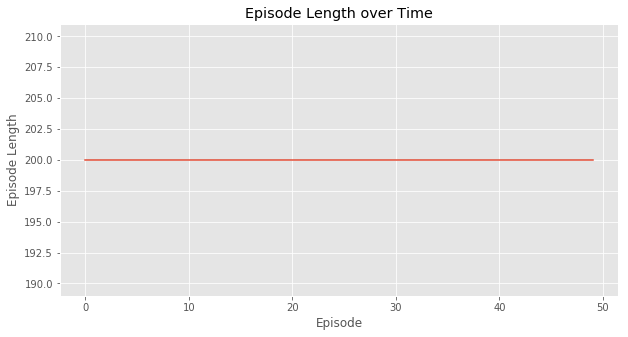

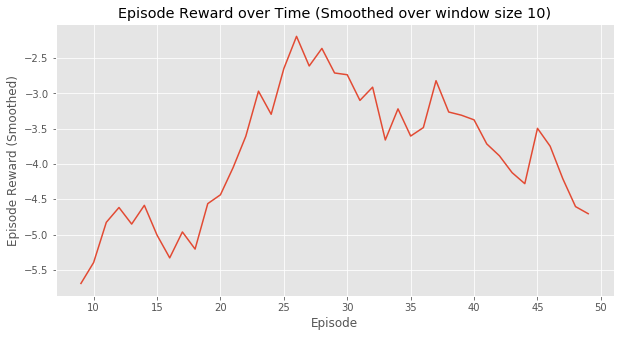

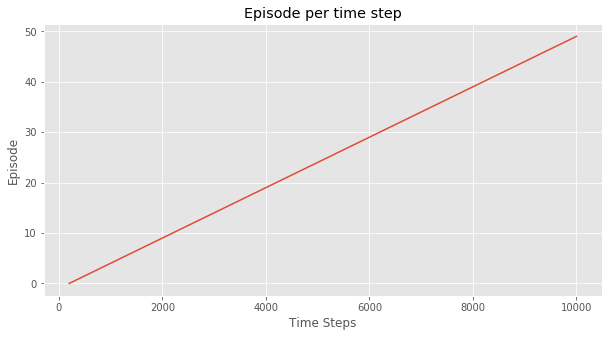

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [11]:
plotting.plot_episode_stats(stats, smoothing_window=10)

In [10]:
#  for t in itertools.count():
#             env.render()
#             # Take a step
#             action_probs = estimator_policy.predict(state)
#             action1 = np.random.choice(np.arange(len(action_probs)), p=action_probs)
#             action2 = np.random.choice(np.arange(len(action_probs)), p=action_probs)
#             action = (action1, action2)
#             next_state, reward, done, _ = env.step(action)